# Tutorial 4: Image analysis

In this exercise, we will employ basic image analysis techniques to isolate the core of the planetary nebula NGC $6543$ (also known as Cat's Eye Nebula), and calculate its radius. Then, using multiwavelength (optical) files, we will visualize how this nebula would appear *through our eyes*!

Please, download files $19$ **b**, **c** and **d**  from https://chandra.harvard.edu/photo/openFITS/multiwavelength_data.html.

**Note**: We'll use `SciencePlots` to make fancy plots with `matplotlib`. It can be installed by typing these commands in your working environment:

```bash
pip install SciencePlots

# or

conda install -c conda-forge scienceplots
```
You can still follow the tutorial without it.

## Activities to do:

(a) Write a python function to extract data from a FITS file. Then, use it on **ngc6543_optical_B.fits** and plot it.

(b) Do a little *cheating* to highlight high values in the data. This will make it easier to isolate features of high intensity :).

(c) Identify a good threshold value for isolating the core of the planetary nebula by reshaping the data in a $1$D array and making a histogram of it. Show the result!

(d) Get a binary image of the isolated core, and use very simple criteria to estimate the radius. 

(e) Now use the `skimage` library (specifically, the functions filters and regionprops) to obtain the center of mass of the image, and estimate the radius again.

(f) Visually compare both results by placing two circles for both radii around the center of mass in the image.

(g) Obtain the predicted radii in physical units by using the conversion factors from pixel to degree units (**CD1_1** and **CD2_1** in the keys).

(h) Reconstruct the optical image by getting the data from the other two files and merging them all. **Hint**: Data needs to be normalized and put together in a $3$D object mantaining the RGB order.

### (a) Write a python function to extract data from a FITS file. Then, use it on **ngc6543_optical_B.fits** and make plot it.

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits 

# If you don't have it working, comment it
import scienceplots

In [2]:
# Function
def get_fits_data(filename):
    '''
    '''
    # Open the file
    fits_file = fits.open(filename)

    # Get the data and keys too
    data = fits_file[0].data
    keys = fits_file[0].header.keys
    
    return data, keys

In [3]:
# Call it
b_2d, keys_b = get_fits_data('./Data/ngc6543_optical_B.fits')

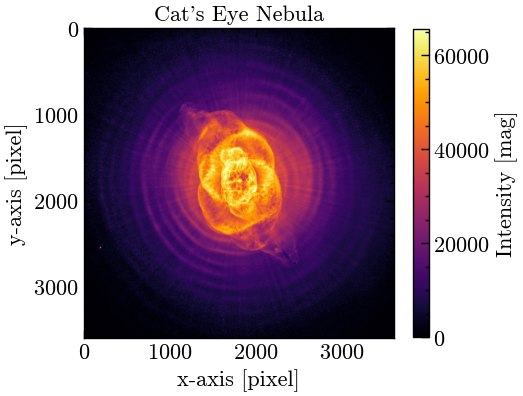

In [4]:
# Plot!
with plt.style.context(['science', 'notebook', 'no-latex']):
    plt.figure(figsize = (5, 5))
    fig = plt.imshow(b_2d, 'inferno')
    cb = plt.colorbar(fig, shrink = 0.8)
    cb.set_label("Intensity [mag]")
    plt.title("Cat's Eye Nebula")
    plt.xlabel('x-axis [pixel]')
    plt.ylabel('y-axis [pixel]')
    plt.show()
    plt.close()

### (b) Do a little *cheating* to highlight high values in the center. This will make it easier to isolate features of high intensity :).

In [5]:
# Make the values smaller so that python does not have problems
epsilon = 1e0
log_b_2d = np.log(b_2d + epsilon)

# And then take the third power of it to *highlight* high values (core)
log_b_2d = log_b_2d**3

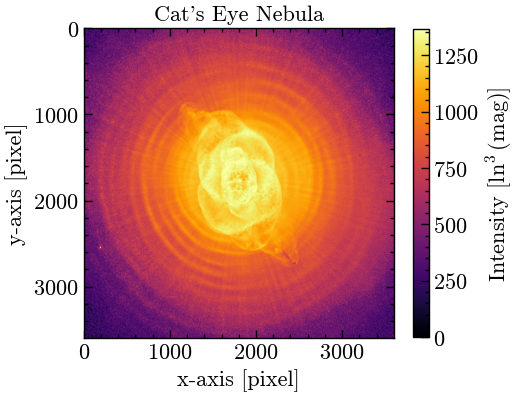

In [6]:
# Let's see how it changes
with plt.style.context(['science', 'notebook', 'no-latex']):
    plt.figure(figsize = (5, 5))
    fig = plt.imshow(log_b_2d, 'inferno')
    cb = plt.colorbar(fig, shrink = 0.8)
    cb.set_label("Intensity [$\\ln^{3}$(mag)]")
    plt.title("Cat's Eye Nebula")
    plt.xlabel('x-axis [pixel]')
    plt.ylabel('y-axis [pixel]')
    plt.show()
    plt.close()

### (c) Identify a good threshold value for isolating the core of the planetary nebula by reshaping the data in a $1$D array and making a histogram of it. Show the result!

In [7]:
# Flatten the array (.size returns the number of elements of the matrix)
b_1d = log_b_2d.reshape((log_b_2d.size, 1))

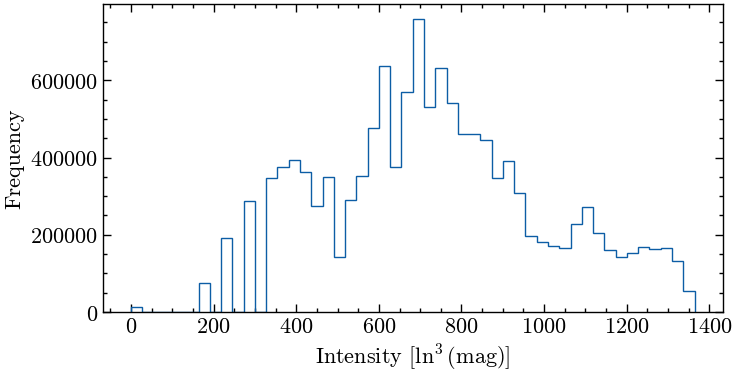

In [8]:
# Histogram
with plt.style.context(['science', 'notebook', 'no-latex']):
    plt.figure(figsize=(8,4))
    plt.hist(b_1d, bins = 50, histtype='step')
    plt.xlabel("Intensity [$\\ln^{3}$(mag)]")
    plt.ylabel('Frequency')
    plt.show()

In [9]:
# Use thresholding!
b_1d_clean = np.where(b_1d < 975, np.nan, b_1d)

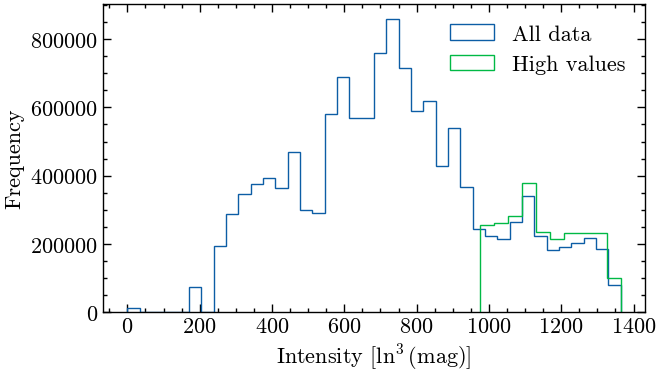

In [10]:
# Both histograms
with plt.style.context(['science', 'notebook', 'no-latex']):
    plt.figure(figsize=(7,4))
    plt.hist(b_1d, bins = 40, histtype='step', label = 'All data')
    plt.hist(b_1d_clean, bins = 10, histtype='step', label = 'High values')
    plt.xlabel("Intensity [$\\ln^{3}$(mag)]")
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    plt.close()

In [11]:
# Now that we have isolated the high values, reshape it
b_2d_clean = b_1d_clean.reshape(b_2d.shape)

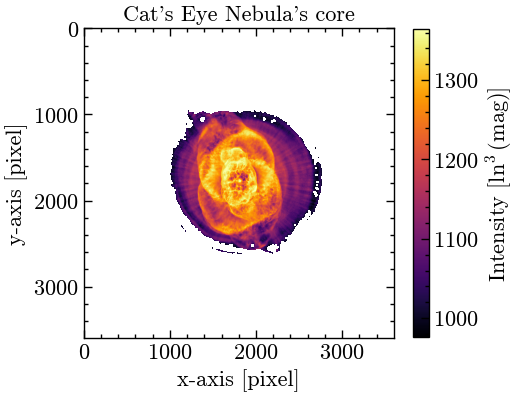

In [12]:
# And plot the result
with plt.style.context(['science', 'notebook', 'no-latex']):
    plt.figure(figsize = (5, 5))
    fig = plt.imshow(b_2d_clean, 'inferno')
    cb = plt.colorbar(fig, shrink = 0.8)
    cb.set_label("Intensity [$\\ln^{3}$(mag)]")
    plt.title("Cat's Eye Nebula's core")
    plt.xlabel('x-axis [pixel]')
    plt.ylabel('y-axis [pixel]')
    plt.show()
    plt.close()

### (d) Get a binary image of the isolated core, and use very simple criteria to estimate the radius. 

In [13]:
# Simply
b_2d_binary = np.where(b_2d_clean > 0, 1, 0)

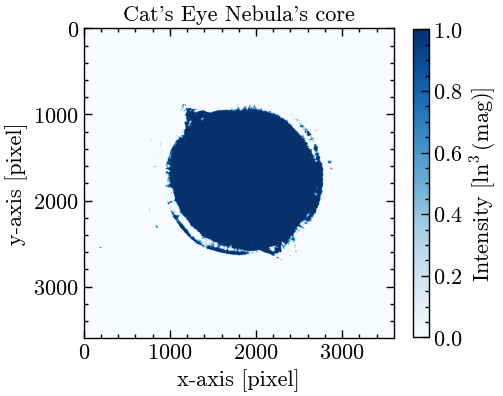

In [14]:
with plt.style.context(['science', 'notebook', 'no-latex']):
    plt.figure(figsize = (5, 5))
    fig = plt.imshow(b_2d_binary, 'Blues')
    cb = plt.colorbar(fig, shrink = 0.8)
    cb.set_label("Intensity [$\\ln^{3}$(mag)]")
    plt.title("Cat's Eye Nebula's core")
    plt.xlabel('x-axis [pixel]')
    plt.ylabel('y-axis [pixel]')
    plt.show()
    plt.close()

#### Rough estimate of the radius

In [15]:
# Simply
x_diam = sum(b_2d_binary[1800])
y_diam = sum(b_2d_binary[:,1800])

In [16]:
# And
radius_1 = (x_diam + y_diam)/4

### (e) Now use the `skimage` library (specifically, `filters` and `regionprops`) to obtain the center of mass of the image, and estimate the radius again.

In [17]:
# Import such functions
from skimage import filters
from skimage.measure import regionprops

#### Let's get a binary file

In [18]:
# Get a threshold value with the Otsu method
threshold_value = filters.threshold_otsu(b_2d)

In [19]:
# 2. Now use the threshold to separate the data
labeled_image = (b_2d > threshold_value).astype(int)

#### Get the properties of the data using the labeled image

In [21]:
# Use region props
properties = regionprops(labeled_image, b_2d)

In [22]:
# Simply obtain the center of mass by using the key .centroid

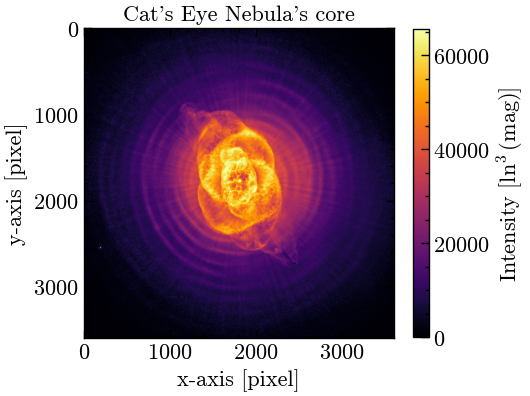

In [23]:
with plt.style.context(['science', 'notebook', 'no-latex']):
    plt.figure(figsize = (5, 5))
    fig = plt.imshow(b_2d, 'inferno')
    cb = plt.colorbar(fig, shrink = 0.8)
    cb.set_label("Intensity [$\\ln^{3}$(mag)]")
    plt.title("Cat's Eye Nebula's core")
    plt.xlabel('x-axis [pixel]')
    plt.ylabel('y-axis [pixel]')
    plt.show()
    plt.close()

#### Second radius estimate

In [24]:
# Similarly
radius_2 = np.mean((properties[0].axis_major_length, properties[0].axis_minor_length))/2

### (f) Visually compare both results by placing two circles for both radii around the center of mass in the image.

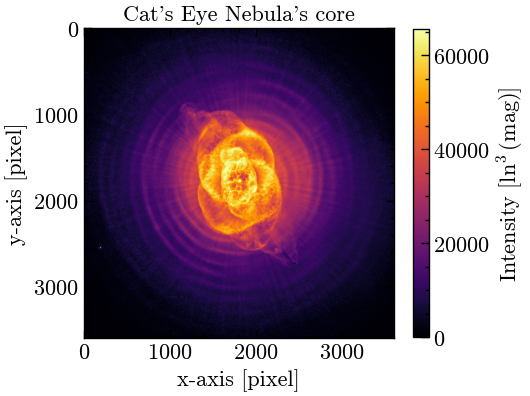

In [25]:
with plt.style.context(['science', 'notebook', 'no-latex']):
    plt.figure(figsize = (5, 5))
    fig = plt.imshow(b_2d, 'inferno')
    cb = plt.colorbar(fig, shrink = 0.8)
    cb.set_label("Intensity [$\\ln^{3}$(mag)]")
    plt.title("Cat's Eye Nebula's core")
    plt.xlabel('x-axis [pixel]')
    plt.ylabel('y-axis [pixel]')
    plt.show()
    plt.close()

### (g) Obtain the predicted radii in physical units by using the conversion factors from pixel to degree units (**CD1_1** and **CD2_1** in the keys).

In [26]:
# Obtain the pixel resolution in radians
angle_estimate = (4.44707382411E-06 + 3.14322677056E-06)/2 # deg
pixel_resolution = angle_estimate*(np.pi/180) # radians

In [27]:
# Define the distance to the nebula
distance = 3262 # ly

In [28]:
# Get the conversion factor
factor = distance*np.tan(pixel_resolution)

In [29]:
# And get the radius in physical units
radius_phys_1 = radius_1*factor
radius_phys_2 = radius_2*factor

### (h) Reconstruct the optical image by getting the data from the other two files and merging them all. **Hint**: Data needs to be normalized and put together in a $3$D object mantaining the RGB order.

In [30]:
# Get the other files
r_2d, _ = get_fits_data('./Data/ngc6543_optical_R.fits')
g_2d, _ = get_fits_data('./Data/ngc6543_optical_G.fits')

In [31]:
# To normalize
def normalize(data):
    '''
    '''
    data = np.array(data)
    norm = (data-np.min(data))/(np.max(data)-np.min(data))
    return norm

In [32]:
# Use it
r_norm = normalize(r_2d)
g_norm = normalize(g_2d)
b_norm = normalize(b_2d)

In [33]:
# Create an empty 3D set with the appropiate shapes
rgb_image = np.zeros((r_norm.shape[0], r_norm.shape[1], 3))

# The order matters! 
rgb_image[:,:, 0] = r_norm 
rgb_image[:,:, 1] = g_norm
rgb_image[:,:, 2] = b_norm

In [34]:
# Let's see our results!

Compare results by clicking on **Optical** here: https://chandra.harvard.edu/photo/2012/pne/.